In [1]:
import os
import requests
import json
import pandas as pd
from pandas import json_normalize
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Part 1: Download API data and create a Data Frame

In [2]:
url = 'https://content.guardianapis.com/search'
MY_API = os.environ.get("API_GUARDIAN")
my_params= {"api-key":MY_API, "q":"chatgpt",  "format":"json", "page":1, "page-size":100}

# input("topic")
response=requests.get(url,params=my_params).json()

res_dict=json_normalize(response['response']['results'])
df = pd.DataFrame(res_dict).reset_index(drop=True)

<AxesSubplot: xlabel='webPublicationDate'>

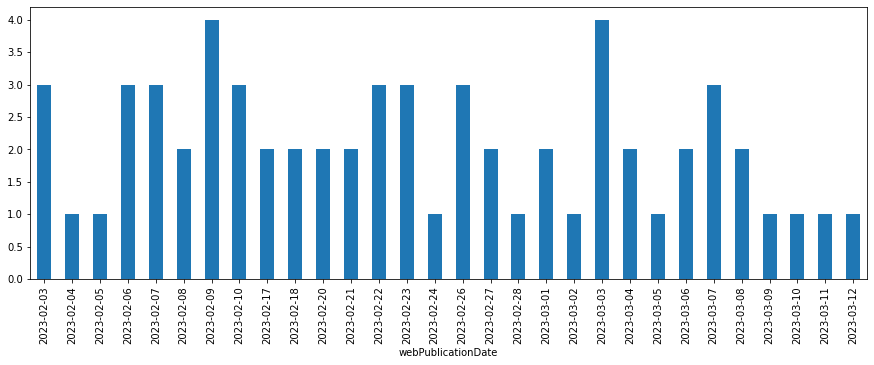

In [3]:
chat_gpt = df.convert_dtypes() #in realtà potrei non doverlo fare. Infatti se uso 'loc' in ogni colonna mi dirà reale type
chat_gpt['webPublicationDate']=pd.to_datetime(chat_gpt['webPublicationDate'],format="%Y-%m-%d")
chat_gpt['webPublicationDate']=chat_gpt['webPublicationDate'].dt.date
#ATTENTO: il fatto che chat_gpt['webPublicationDate'].dtype ti dia 'object' non significa che non sia 'datetime'.
#Infatti se fai: chat_gpt.loc[10,'webPublicationDate'] ti darà 'datetime'. Confermato su stackoverflow
chat_gpt.sort_values('webPublicationDate',ascending=False,inplace=True)
#NUMBER OF ARTICLES AT DAY
n_art=chat_gpt.groupby('webPublicationDate')['id'].nunique().reset_index(name='Articles for days')
n_art.set_index('webPublicationDate')['Articles for days'].tail(30).plot(kind='bar',figsize=(15,5))

# PART 2: Tokenization and Wordclouds

In [4]:
import spacy
from spacy import displacy

nlp=spacy.load("en_core_web_sm")
ruler=nlp.add_pipe("entity_ruler",before='ner')
patterns1=[{'label':'Skynet','pattern':'ChatGPT'}]
patterns2=[{'label':'Skynet', 'pattern':[{'TEXT':{'REGEX':r"\b(AI)\b"}}]}]
patterns3=[{'label':'Skynet','pattern':[{'TEXT':{'REGEX':r"\b(chatbot)\b"}}]}]
patterns4=[{'label':'Skynet', 'pattern':[{'TEXT':{'REGEX':r"\b(Bard)\b"}}]}]
ruler.add_patterns(patterns1)
ruler.add_patterns(patterns2)
ruler.add_patterns(patterns3)
ruler.add_patterns(patterns4)

In [5]:
entity_list=[]
chat_gpt_doc=list(nlp.pipe(chat_gpt['webTitle']))
for doc in chat_gpt_doc:
    for s in doc.sents:
        entities=[e.text for e in s.ents]
        labels=[e.label_ for e in s.ents]
        entity_list.append({'Sents':s,'Entities':entities,'Labels':labels})
df_entity=pd.DataFrame(entity_list)
df_entity = df_entity[df_entity['Entities'].map(len)>0]
df_entity.head(10)

,Sents,Entities,Labels
0,"(Lineker, and, Vorderman, are, a, more, effect...","[Lineker, Vorderman, Labour]","[ORG, PERSON, ORG]"
1,"(No, wonder, the, Tories, feel, threatened, |,...","[Tories, Hannah Jane]","[NORP, PERSON]"
2,"(Users, ,, advertisers, –, we, are, all, trapp...",[John Naughton],[PERSON]
3,"(Antisocial, media, :, ABC, goes, on, warpath,...","[ABC, Lisa Millar’s, Weekly Beast]","[ORG, PERSON, ORG]"
4,"(Harness, the, power, of, AI, to, boost, your,...",[AI],[Skynet]
5,"(ChatGPT, ’s, alter, ego, ,, Dan, :, users, ja...","[ChatGPT, Dan, AI]","[Skynet, PERSON, Skynet]"
6,"(Darktrace, warns, of, rise, in, AI, -, enhanc...","[Darktrace, AI, ChatGPT]","[ORG, Skynet, Skynet]"
7,"(Mirror, and, Express, owner, publishes, first...","[Mirror, Express, first, AI]","[ORG, ORG, ORDINAL, Skynet]"
8,"(Football, Daily, |, Wo, n’t, somebody, please...",[Football Daily],[ORG]
9,"(TechScape, :, Will, Meta, ’s, massive, leak, ...","[Meta, AI]","[ORG, Skynet]"


In [6]:
for e in chat_gpt_doc:
    displacy.render(e,style='ent')

## 2.1 = Just a Wordcloud Visualization

In [7]:
import numpy as np
import os
from PIL import Image
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [8]:
list_words=[]
for e in df_entity['Entities']:
    list_words.extend(e)

lab=[]
for l in df_entity['Labels']:
    lab.extend(l)

mystop=["John Naughton","Australia","Turkey","Syria","Guardian"]

for i,v in enumerate(lab):
    for j,k in enumerate(list_words):
        if k in mystop:
            list_words.pop(j)
            lab.pop(i)

In [9]:
d=os.getcwd()
stop=set(STOPWORDS)
stop.update(mystop) #stop.add(str(mystop))
my_mask=np.array(Image.open(d+"/chatgpt-logo.png"))
wc=WordCloud(stopwords=stop,mask=my_mask,background_color='black',contour_width=2,contour_color='white').generate(str(list_words))
wc.to_image().show()
#Alternative:
# import matplotlib.pyplot as plt
# plt.imshow(wc,interpolation='bilinear',
# cmap=plt.cm.cividis)
# plt.axis('off')
# plt.figure()
# plt.show()

## 2.2 = ENTITIES: COUNT & COMBINATIONS

In [10]:
from collections import Counter,OrderedDict
a=dict(Counter(list_words).items())
b=OrderedDict(sorted(a.items(),key=lambda x:x[1],reverse=True))
series = pd.Series(b)

In [11]:
import itertools 
from itertools import combinations
combo=[]
for e in df_entity['Entities']:
    l=list(combinations(e,2))
    combo.extend(l)

c=dict(Counter(combo).items())

In [12]:
duplicates = set()
for key_tuple in list(c.keys()):
        if key_tuple in duplicates or (key_tuple[1], key_tuple[0]) in duplicates:
            c.pop(key_tuple)
        duplicates.add(key_tuple)
o=OrderedDict(sorted(c.items(),key=lambda x:x[1],reverse=True))
series_combo = pd.Series(o)

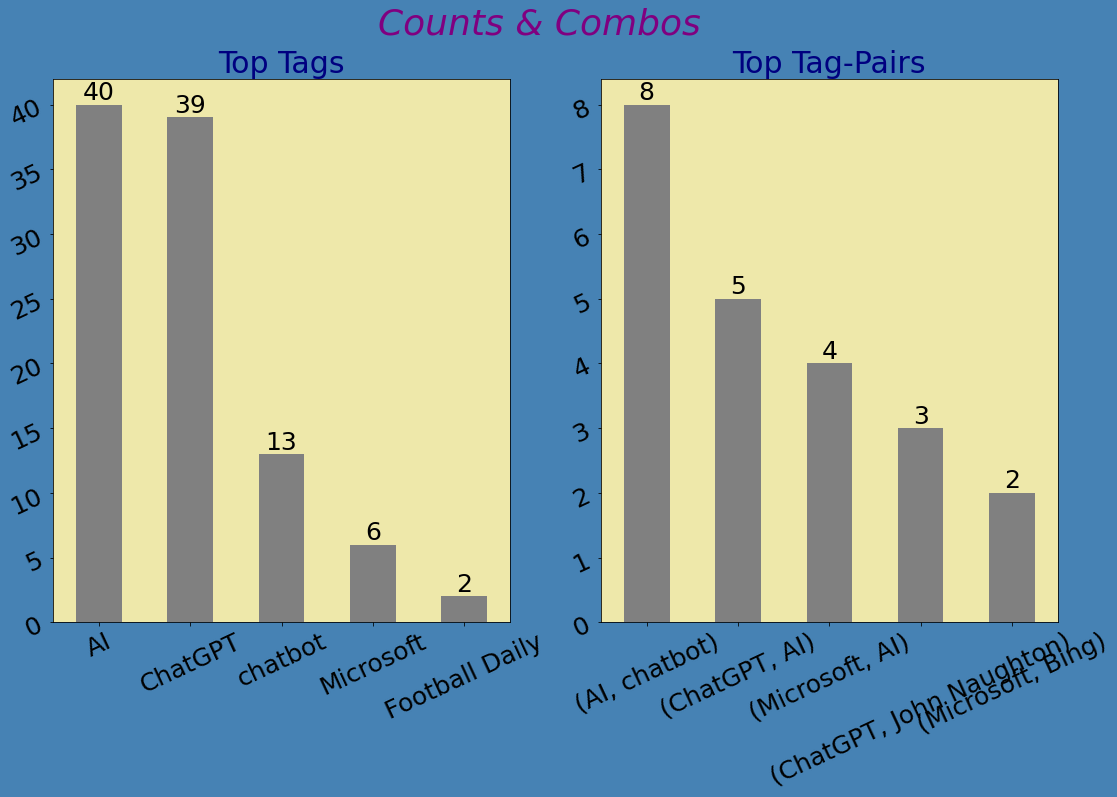

In [13]:
plt.rcParams['font.size'] = 25
fig,ax=plt.subplots(1,2,figsize=(18,10))
fig.set_facecolor('steelblue')
ax[0].set_facecolor('palegoldenrod')
ax[1].set_facecolor('palegoldenrod')

s1=series[:5].plot(kind='bar',color='gray',ax=ax[0])
s2=series_combo[:5].plot(kind='bar',color='gray',ax=ax[1])

ax[0].bar_label(s1.containers[0])
ax[1].bar_label(s2.containers[0])

plt.suptitle('Counts & Combos',color='purple',size='x-large',style='oblique')
ax[0].set_title('Top Tags',color='navy')
ax[1].set_title('Top Tag-Pairs',color='navy')

ax[0].tick_params(labelrotation=25)
ax[1].tick_params(labelrotation=25)
plt.show()

# Part 3: NetworkX

In [14]:
import networkx as nx

#Creating a DataFrame including Node Source(NodeA), Node Target(NodeB), and values
df_combo=pd.DataFrame.from_dict(series_combo).reset_index()
df_combo.rename(columns={'level_0':'NodeA','level_1':'NodeB',0:'Values'},inplace=True)

G=nx.from_pandas_edgelist(df_combo,source='NodeA',target='NodeB',edge_attr='Values')

## 3.1 Network Visualization (PYVIS)

In [15]:
from pyvis.network import Network
n_degree=dict(G.degree())
nx.set_node_attributes(G,n_degree,'size')
plt.rcParams["figure.figsize"]=(15,10)
# mypos=nx.kamada_kawai_layout(G)
# nx.draw_networkx(G,arrows=True,pos=mypos)
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
net.from_nx(G)
net.show("Skynet.html")

In [16]:
#We see ChatGPT shows the most of connections.
#We can prove it by checking its 'degrees':
sorted(G.degree,key=lambda x: x[1],reverse=True)

[('AI', 29),
 ('ChatGPT', 26),
 ('chatbot', 8),
 ('Microsoft', 7),
 ('Bing', 5),
 ('Google', 4),
 ('John Naughton', 3),
 ('Bard', 3),
 ('Mirror', 3),
 ('Express', 3),
 ('first', 3),
 ('three', 3),
 ('Australia', 3),
 ('Jim Molan', 3),
 ('Renée Geyer', 3),
 ('Victoria', 3),
 ('five-minute', 3),
 ('Nick Cave', 3),
 ('Lineker', 2),
 ('Vorderman', 2),
 ('Labour', 2),
 ('ABC', 2),
 ('Lisa Millar’s', 2),
 ('Weekly Beast', 2),
 ('Dan', 2),
 ('Darktrace', 2),
 ('China', 2),
 ('Whitehall', 2),
 ('Magnus Carlsen', 2),
 ('Levon Aronian', 2),
 ('Düsseldorf', 2),
 ('German', 2),
 ('Axel Springer', 2),
 ('TechScape', 2),
 ('Seven', 2),
 ('Jimmy Kimmel', 2),
 ('Trump', 2),
 ('East Palestine', 2),
 ('Vanderbilt', 2),
 ('Michigan', 2),
 ('US', 2),
 ('100 million', 2),
 ('two months', 2),
 ('OpenAI', 2),
 ('multibillion dollar', 2),
 ('El Niño', 2),
 ('Nepal', 2),
 ('Excel', 2),
 ('New York City', 2),
 ('Australian', 1),
 ('Guardian', 1),
 ('Tories', 1),
 ('Hannah Jane', 1),
 ('Meta', 1),
 ('Xi Jinping'

In [17]:
'''----CHECKS-----'''
# G.nodes
# G.edges
# G['ChatGPT']['AI']['Values']
# G.nodes['Bard']['size']

'----CHECKS-----'

## 3.2 = Creating and visualizing groups by using Community

### 3.2 Method 1

In [18]:
import community.community_louvain as community_louvain
groups = community_louvain.best_partition(G) 

nx.set_node_attributes(G, groups, 'group')
group_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
group_net.from_nx(G)
group_net.show("skynet_communities.html")

### 3.2 Method 2

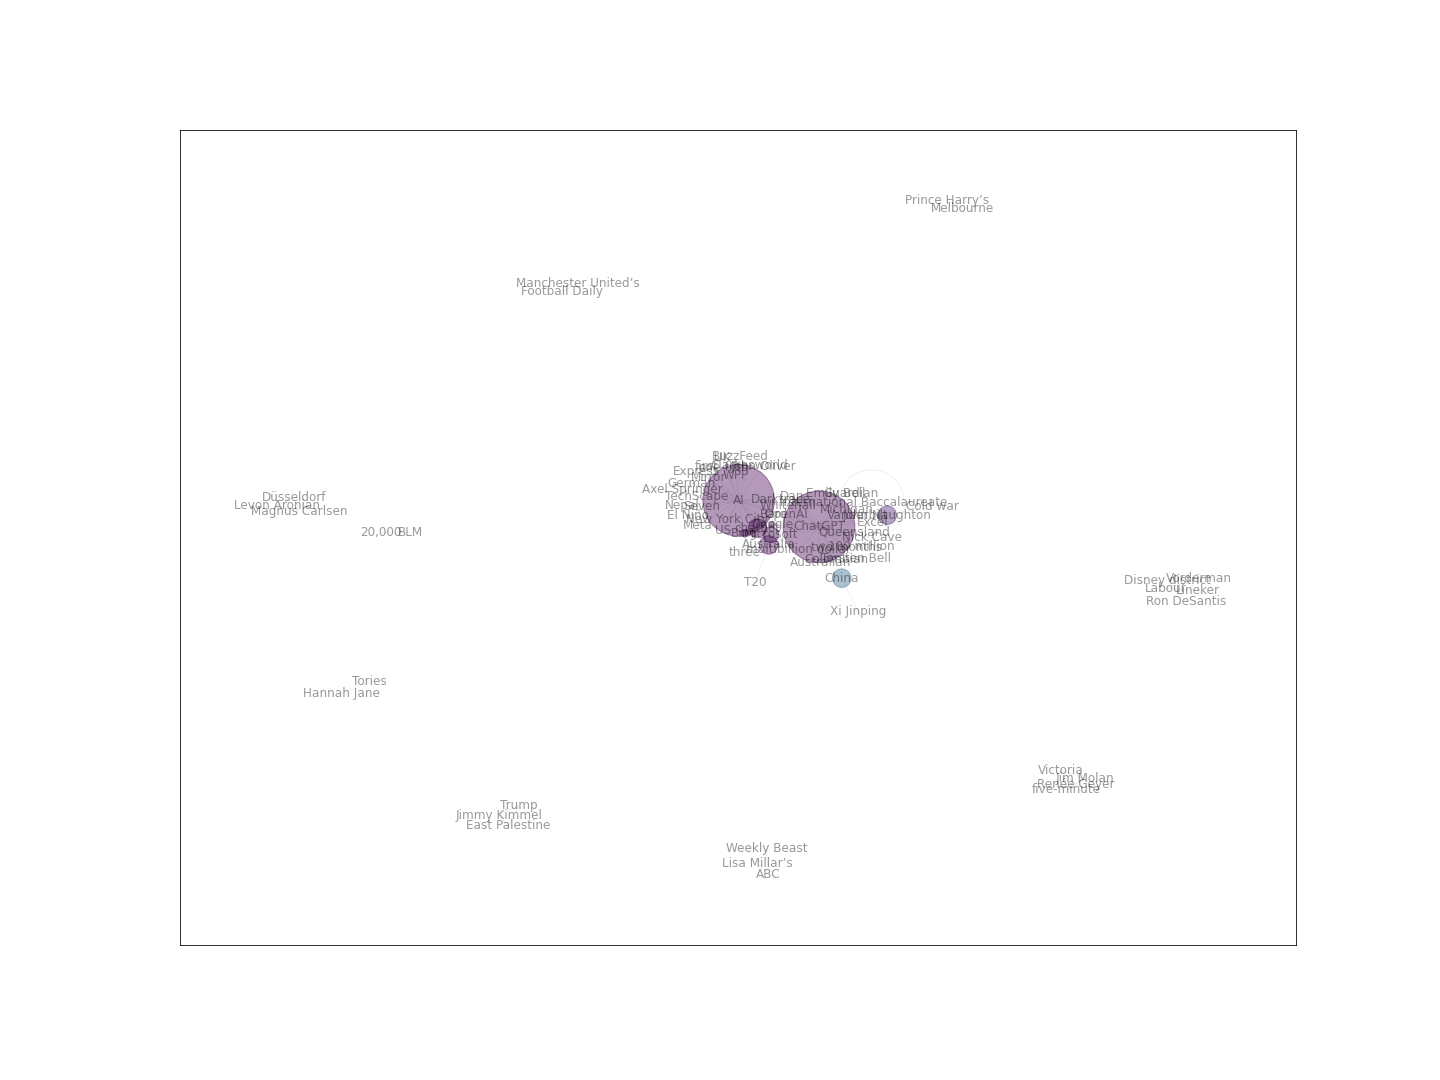

In [19]:
%matplotlib widget
centrality = nx.betweenness_centrality(G)

lpc = nx.community.label_propagation_communities(G)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

# We now plot our Network's nodes broken down into categories built by "community.label_propagation_communities"
# According the nature of nodes and the groups they belong to, we plot them in different size and colors
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(G)
node_color = [community_index[n] for n in G]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4)

In [20]:
#If we want to check how different are groups created by these 2 methods:
M1=sorted(community_index.items(),key=lambda x: x[1],reverse=True)
M2=sorted(groups.items(),key=lambda x: x[1],reverse=True)

print(M1,M2,sep="\n"*2)

[('Melbourne', 15), ('Prince Harry’s', 15), ('Nick Cave', 14), ('Renée Geyer', 13), ('five-minute', 13), ('Victoria', 13), ('Jim Molan', 13), ('two months', 12), ('100 million', 12), ('20,000', 11), ('BLM', 11), ('Manchester United’s', 10), ('Football Daily', 10), ('Vanderbilt', 9), ('Michigan', 9), ('East Palestine', 8), ('Trump', 8), ('Jimmy Kimmel', 8), ('Ron DeSantis', 7), ('Disney district', 7), ('Magnus Carlsen', 6), ('Düsseldorf', 6), ('Levon Aronian', 6), ('Xi Jinping', 5), ('China', 5), ('Lisa Millar’s', 4), ('Weekly Beast', 4), ('ABC', 4), ('Tories', 3), ('Hannah Jane', 3), ('Vorderman', 2), ('Labour', 2), ('Lineker', 2), ('Cold war', 1), ('Excel', 1), ('John Naughton', 1), ('WPP', 0), ('Guardian', 0), ('Whitehall', 0), ('Mirror', 0), ('El Niño', 0), ('ChatGPT', 0), ('TechScape', 0), ('OpenAI', 0), ('Dan', 0), ('first', 0), ('T20', 0), ('Seven', 0), ('Meta', 0), ('Australia', 0), ('Microsoft', 0), ('UK', 0), ('multibillion dollar', 0), ('John Oliver', 0), ('BuzzFeed', 0), ('o

# 3.3 = Plot networks' connections between entities and labels

In [21]:
entity_list2=[]
for i2,doc in enumerate(chat_gpt_doc):
    for s in doc.sents:
        entities=[e.text for e in s.ents]
        labels=[e.label_ for e in s.ents]
        section=chat_gpt['sectionName'][i2]
        entity_list2.append({'Sents':s,'Entities':entities,'Labels':labels,'Section':section})
df_entity2=pd.DataFrame(entity_list2)
df_entity2 = df_entity2[df_entity2['Entities'].map(len)>0]
df_entity2.head(10)

,Sents,Entities,Labels,Section
0,"(Lineker, and, Vorderman, are, a, more, effect...","[Lineker, Vorderman, Labour]","[ORG, PERSON, ORG]",Crosswords
1,"(No, wonder, the, Tories, feel, threatened, |,...","[Tories, Hannah Jane]","[NORP, PERSON]",Crosswords
2,"(Users, ,, advertisers, –, we, are, all, trapp...",[John Naughton],[PERSON],Education
3,"(Antisocial, media, :, ABC, goes, on, warpath,...","[ABC, Lisa Millar’s, Weekly Beast]","[ORG, PERSON, ORG]",Technology
4,"(Harness, the, power, of, AI, to, boost, your,...",[AI],[Skynet],Technology
5,"(ChatGPT, ’s, alter, ego, ,, Dan, :, users, ja...","[ChatGPT, Dan, AI]","[Skynet, PERSON, Skynet]",Australia news
6,"(Darktrace, warns, of, rise, in, AI, -, enhanc...","[Darktrace, AI, ChatGPT]","[ORG, Skynet, Skynet]",Technology
7,"(Mirror, and, Express, owner, publishes, first...","[Mirror, Express, first, AI]","[ORG, ORG, ORDINAL, Skynet]",Technology
8,"(Football, Daily, |, Wo, n’t, somebody, please...",[Football Daily],[ORG],Technology
9,"(TechScape, :, Will, Meta, ’s, massive, leak, ...","[Meta, AI]","[ORG, Skynet]",Opinion


In [22]:
ent = [x2 for x in df_entity2['Entities'] for x2 in x]
sec = [x for x in df_entity2['Section']]

nod = list(set(ent+sec))
ed=[]
a=list(zip(df_entity2['Entities'],df_entity2['Section']))
for i in a:
    for i2 in i[0]:
        ed.append((i2,i[1]))

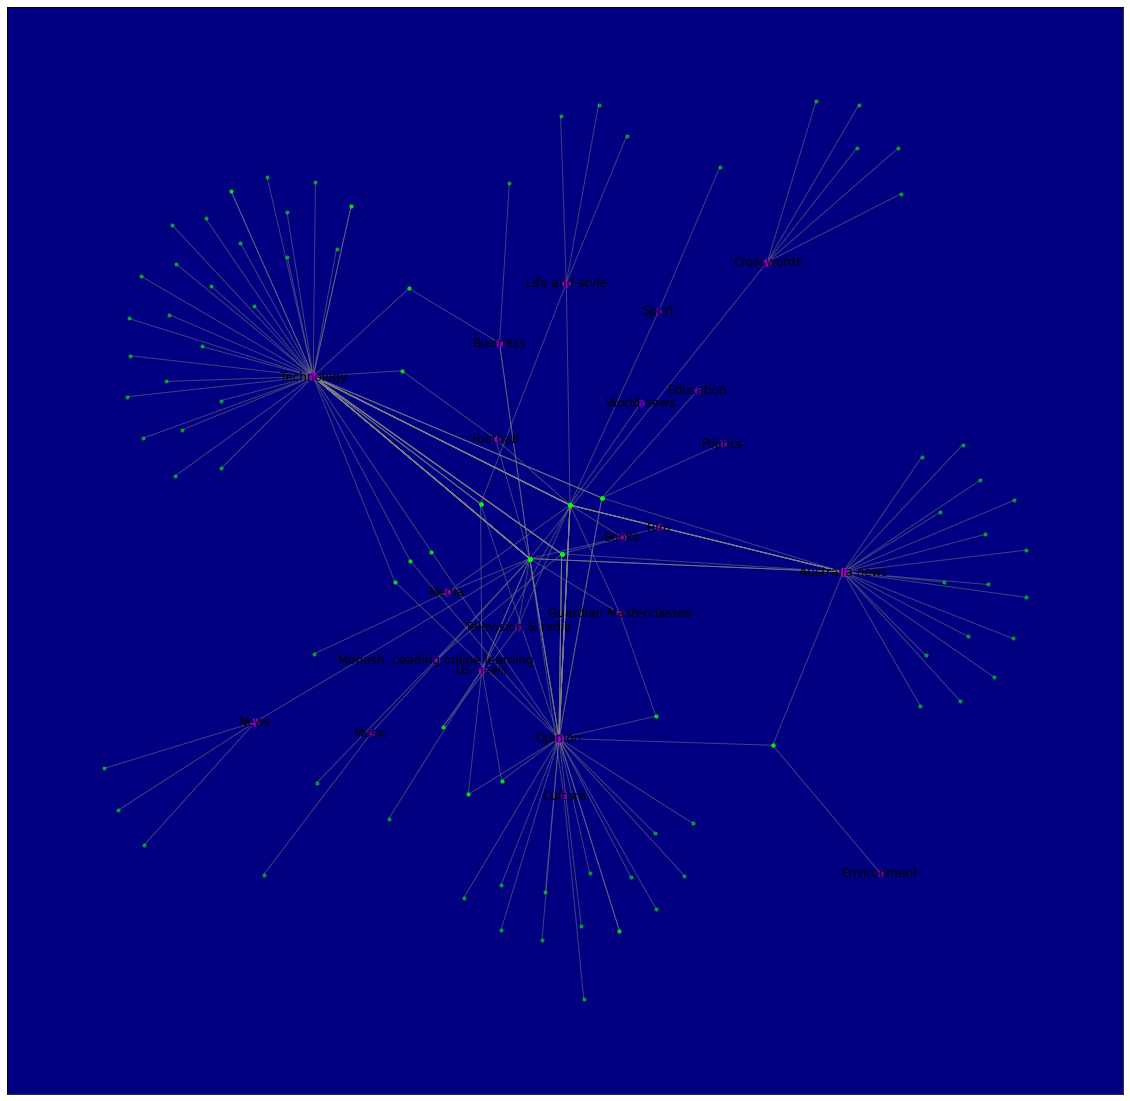

In [30]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('navy')
g = nx.Graph()


g.add_nodes_from(ent, label='entities')
g.add_nodes_from(sec, label='section')
g.add_edges_from(ed)

#Labels: simple but a mess
# labels={x:x for x in nod}

labels = {}
for node in nod:
    if node in sec:
        labels[node] = node


pos = nx.spring_layout(g)
# pos = nx.spiral_layout(g)
nx.draw_networkx_nodes(g,pos=pos,
                       nodelist=ent,
                       node_color='lime',
                       node_size=10,
                       alpha=0.5)

nx.draw_networkx_nodes(g,pos=pos,
                       nodelist=sec,
                       node_color='darkviolet',
                       node_size=50,
                       alpha=0.5)

nx.draw_networkx_edges(g,pos=pos,
                       edgelist=ed,
                       width=1,alpha=0.5,edge_color='grey')

nx.draw_networkx_labels(g, pos=pos,
                        labels=labels)

# plt.savefig("Nodes&Labels.png", format="PNG")
plt.show()